In [2]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

### Data

datetime - hourly date + timestamp
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

In [41]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("./Data/train.csv")
train['datetime'] = pd.to_datetime(train['datetime'])
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

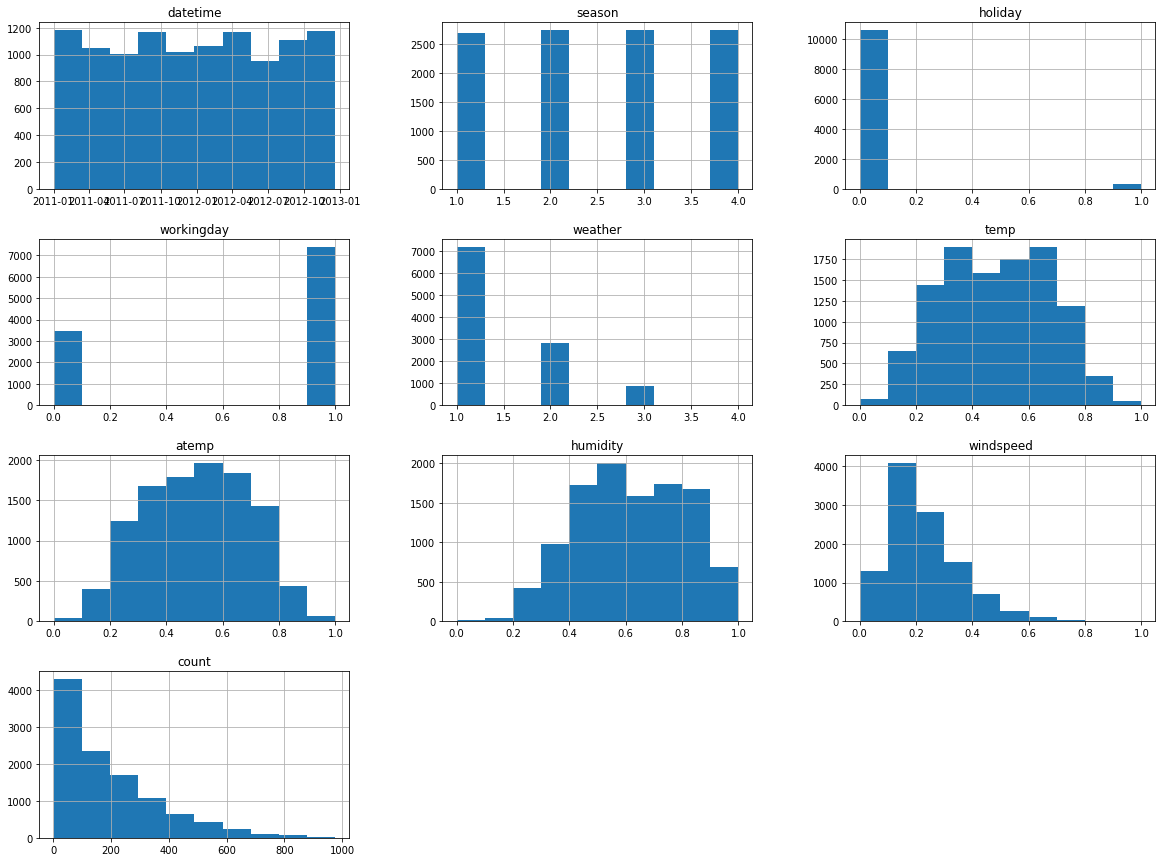

In [154]:
# Histogram to show all the data distributions including the target
%matplotlib inline

train.hist(figsize=(20, 15))

In [156]:
# Investigate to see if any data are correlated positively or negatively
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [42]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [43]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./Data/test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [63]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [44]:
# Same thing as train and test dataset
submission = pd.read_csv("./Data/sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [64]:
submission.describe()

,count
count,6493.000000
mean,100.389969
std,89.943405
min,3.319188
25%,19.963657
50%,63.284554
75%,169.917923
max,364.556915


### Model

Requirements:
- We are predicting count, so it is the label we are setting.
- Ignore casual and registered columns as they are also not present in the test dataset.
- Use the root_mean_squared_error as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset best_quality to focus on creating the best model.

In [71]:
learner_kwargs = {
    'ignored_columns': ['casual', 'registered']
}

In [72]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_213655\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220718_213655\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2137.93 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fittin

In [76]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.428314      25.042783  425.511158                0.000554           1.145018            3       True         18
1   NeuralNetFastAI_BAG_L2  -51.575689      23.381067  408.094586                1.104650          53.252690            2       True         16
2   RandomForestMSE_BAG_L2  -53.192385      23.210769  365.772005                0.934352          10.930110            2       True         13
3     ExtraTreesMSE_BAG_L2  -53.639684      23.003228  360.183340                0.726810           5.341444            2       True         15
4          LightGBM_BAG_L2  -54.730151      22.635210  360.856817                0.358792           6.014921            2       True         12
5           XGBoost_BAG_L2  -55.278658      22.571365  366.612289         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_pe

In [77]:
predictions = predictor.predict(test)

In [78]:
predictions.head()

0    25.388779
1    41.943302
2    46.481602
3    48.296814
4    50.782539
Name: count, dtype: float32

In [79]:
predictions.describe()

count    6493.000000
mean       99.140678
std        88.224846
min         0.477703
25%        20.877464
50%        66.991837
75%       165.549103
max       351.056091
Name: count, dtype: float64

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [82]:
submission.head(100)

,datetime,count
0,2011-01-20 00:00:00,25.388779
1,2011-01-20 01:00:00,41.943302
2,2011-01-20 02:00:00,46.481602
3,2011-01-20 03:00:00,48.296814
4,2011-01-20 04:00:00,50.782539
...,...,...
95,2011-01-24 01:00:00,71.526871
96,2011-01-24 03:00:00,71.932152
97,2011-01-24 04:00:00,60.287888
98,2011-01-24 05:00:00,60.292976


In [84]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission attempt: 3"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
100%|##########| 195k/195k [00:00<00:00, 280kB/s]


## Obtained first raw score of 1.80763

# Feature Engineering

In [93]:
# First, normalize the features temperature, relative temperature, humidity, and windspeed
from sklearn.preprocessing import MinMaxScaler

In [96]:
scaler = MinMaxScaler()
# transform data (training)
temp = train['temp'].values.reshape(-1, 1)
atemp = train['atemp'].values.reshape(-1, 1)
humidity = train['humidity'].values.reshape(-1, 1)
windspeed = train['windspeed'].values.reshape(-1, 1)
train['temp'] = scaler.fit_transform(temp)
train['atemp'] = scaler.fit_transform(atemp)
train['humidity'] = scaler.fit_transform(humidity)
train['windspeed'] = scaler.fit_transform(windspeed)

In [99]:
# transform test data too for later
tempt = test['temp'].values.reshape(-1, 1)
atempt = test['atemp'].values.reshape(-1, 1)
humidityt = test['humidity'].values.reshape(-1, 1)
windspeedt = test['windspeed'].values.reshape(-1, 1)
test['temp'] = scaler.fit_transform(tempt)
test['atemp'] = scaler.fit_transform(atempt)
test['humidity'] = scaler.fit_transform(humidityt)
test['windspeed'] = scaler.fit_transform(windspeedt)

In [101]:
predictor_normalized = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs).fit(
    train_data = train,
    time_limit = 100,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220718_220011\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to "AutogluonModels/ag-20220718_220011\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3443.59 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fittin

In [102]:
predictor_normalized.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -54.613405      21.824050  66.442641                0.000000           0.168001            3       True         10
1         LightGBM_BAG_L2  -54.624243      17.967371  52.900547                0.250231           5.640877            2       True          9
2       LightGBMXT_BAG_L2  -60.912757      21.573819  60.633763                3.856679          13.374093            2       True          8
3     WeightedEnsemble_L2  -84.146423       0.033482   0.539645                0.000000           0.466699            2       True          7
4   KNeighborsDist_BAG_L1  -84.146423       0.033482   0.072946                0.033482           0.072946            1       True          2
5   KNeighborsUnif_BAG_L1 -101.588176       0.030992   0.094839                0.03099

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.58817625927213,
  'KNeighborsDist_BAG_L1': -84.14642264302962,
  'LightGBMXT_BAG_L1': -131.376690801181,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.53587644360984,
  'CatBoost_BAG_L1': -137.27000137760038,
  'WeightedEnsemble_L2': -84.14642264302962,
  'LightGBMXT_BAG_L2': -60.912757320283724,
  'LightGBM_BAG_L2': -54.62424319028297,
  'WeightedEnsemble_L3': -54.61340544288559},


In [104]:
predictions_normalized = predictor_normalized.predict(test)

In [137]:
predictions_normalized.head()

0    32.821739
1    42.544937
2    46.057392
3    49.508232
4    50.222870
Name: count, dtype: float32

In [108]:
predictions_normalized.describe()

count    6493.000000
mean      100.295258
std        89.984291
min        -6.651858
25%        17.808601
50%        63.910889
75%       170.488876
max       369.346191
Name: count, dtype: float64

In [114]:
predictions_normalized[predictions_normalized < 0]

5631   -6.651858
Name: count, dtype: float32

In [143]:
predictions_normalized_n = pd.DataFrame(predictions_normalized)
predictions_normalized = predictions_normalized_n.clip(lower=0)

In [144]:
submission["count"] = predictions_normalized
submission.to_csv("submission_normalized.csv", index=False)

In [145]:
!kaggle competitions submit -c bike-sharing-demand -f submission_normalized.csv -m "try normalized features"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
 94%|#########4| 184k/195k [00:00<00:00, 1.87MB/s]
100%|##########| 195k/195k [00:00<00:00, 247kB/s] 


## New score (with normalized features): 1.79863

In [146]:
# Now lets seperate date/month/time column

In [160]:
train['year'] = pd.DatetimeIndex(train['datetime']).year
train['month'] = pd.DatetimeIndex(train['datetime']).month
train['day'] = pd.DatetimeIndex(train['datetime']).day
train['hour'] = pd.DatetimeIndex(train['datetime']).hour

test['year'] = pd.DatetimeIndex(test['datetime']).year
test['month'] = pd.DatetimeIndex(test['datetime']).month
test['day'] = pd.DatetimeIndex(test['datetime']).day
test['hour'] = pd.DatetimeIndex(test['datetime']).hour

In [161]:
# turn into categories
train["season"] = train.season.astype('category')
train["weather"] = train.weather.astype('category')
test["season"] = test.season.astype('category')
test["weather"] = test.season.astype('category')

In [163]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,0.224490,0.305068,0.81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,0.204082,0.288064,0.80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,0.204082,0.288064,0.80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,0.224490,0.305068,0.75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,0.224490,0.305068,0.75,0.0,1,2011,1,1,4


In [166]:
learner_kwargs_new = {
    'ignored_columns': ['casual', 'registered', 'datetime']
}

In [169]:
predictor_new_features = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error", learner_kwargs=learner_kwargs_new).fit(
    train_data = train,
    time_limit = 600,
    presets = "best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220719_212944\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220719_212944\"
AutoGluon Version:  0.5.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered', 'datetime']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2599.6 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generato

In [170]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.327567      31.525754  534.061895                0.000000           0.223697            3       True         18
1   NeuralNetFastAI_BAG_L2  -35.769716      30.194975  388.239176                0.389047          24.398873            2       True         17
2          CatBoost_BAG_L2  -35.897898      29.983325  495.353565                0.177397         131.513262            2       True         15
3     ExtraTreesMSE_BAG_L2  -35.914085      30.291250  366.074793                0.485322           2.234490            2       True         16
4          LightGBM_BAG_L2  -35.979121      29.956012  368.337570                0.150084           4.497268            2       True         13
5      WeightedEnsemble_L2  -36.010718      27.488872  314.132912         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsemb

In [171]:
predictions_new_features = predictor_new_features.predict(test)

In [172]:
predictions_new_features.head()

0    12.982582
1     6.399722
2     4.766326
3     3.452071
4     3.687432
Name: count, dtype: float32

In [173]:
predictions_new_features.describe()

count    6493.000000
mean      178.012970
std       161.528534
min        -1.681530
25%        45.272964
50%       140.856476
75%       264.509888
max       864.865356
Name: count, dtype: float64

In [177]:
predictions_new_features[predictions_new_features < 0].size

6

In [178]:
predictions_new_features = predictions_new_features.clip(lower=0)

In [179]:
submission["count"] = predictions_new_features
submission.to_csv("submission_new_features.csv", index=False)

In [181]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "added new features (2)"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/194k [00:00<?, ?B/s]
  4%|4         | 8.00k/194k [00:01<00:25, 7.56kB/s]
 41%|####1     | 80.0k/194k [00:01<00:01, 67.1kB/s]
 49%|####9     | 96.0k/194k [00:01<00:01, 55.3kB/s]
 58%|#####7    | 112k/194k [00:03<00:02, 30.6kB/s] 
 74%|#######4  | 144k/194k [00:03<00:01, 38.6kB/s]
 82%|########2 | 160k/194k [00:06<00:01, 19.7kB/s]
 90%|######### | 176k/194k [00:06<00:00, 21.5kB/s]
 95%|#########4| 184k/194k [00:07<00:00, 20.3kB/s]
 99%|#########8| 192k/194k [00:08<00:00, 16.3kB/s]
100%|##########| 194k/194k [00:08<00:00, 14.8kB/s]
100%|##########| 194k/194k [00:11<00:00, 17.4kB/s]


## new score: 0.50277!

# Hyperparameter Optimization

In [182]:
# Autogluon only comes with random search, but now we will play with the parameters